In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 


In [3]:
file = './rhum.mon.mean.nc'
dataset = nc.Dataset(file)
# print(dataset.variables.keys())

longitude, latitude = dataset.variables['lon'],dataset.variables['lat']
time = dataset.variables['time']
level =dataset.variables['level']
rhum = dataset.variables['rhum']

In [4]:
# time从1948年1月开始计算，903/12为75余3，正好是2023年3月
# 第一阶段从(1982 - 1948 + 1) * 12 =420 开始到 612结束
# 因为列表从0开始计算，故第一阶段时间区间为[419, 611]
num_month = time[:].data.shape[0] # 时间的size
num_month_1997to1982 = (1998 - 1982) * 12 #计算1982年1月到1997年12月的192月数
# 第二阶段从613开始到 900结束
# 因为列表从0开始计算，故第一阶段时间区间为[612, 899]
num_month_2021to1998 = (2022 - 1998) * 12 #计算1998年1月到2021年12月的288月数

# 选择level是700
# 创建三纬空矩阵(time, lat, lon)
sum_month = np.zeros(rhum[:1,3:4].data[0][:,:].shape, dtype=float, order='C') 
sum_month_1982to1997 = sum_month
count = 0
ls_first = []
mean_1982to1997 = sum_month
# 循环时间
for i in range(420, 612): 
    temp_pre = rhum[i:i+1,3:4].data[0][:,:]
#     ls_first.append(sst[i:i+1].data[0][:1,-1:])
    sum_month_1982to1997 += temp_pre
    count += 1
mean_1982to1997 = sum_month_1982to1997 / num_month_1997to1982

sum_month = np.zeros(rhum[:1,3:4].data[0][:,:].shape, dtype=float, order='C')  # 创建空矩阵
sum_month_1998to2021 = sum_month
count = 0
ls_first = []
mean_1998to2021 = sum_month
for i in range(612, 899): 
    temp_pre = rhum[i:i+1,3:4].data[0][:,:]
#     ls_first.append(sst[i:i+1].data[0][:1,-1:])
    sum_month_1998to2021 += temp_pre
    count += 1
mean_1998to2021 = sum_month_1998to2021 / num_month_2021to1998

diff = mean_1998to2021 - mean_1982to1997

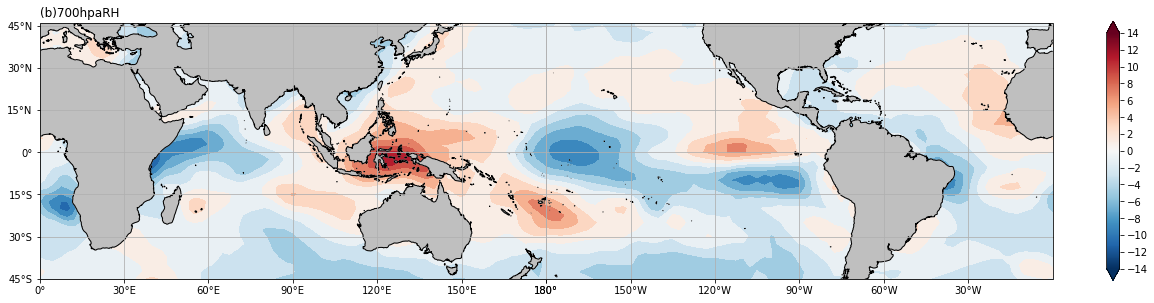

In [5]:
# 设置经纬度
# lon = longitude[:].data
lon = np.append(longitude[:].data, [360.0])
lat = latitude[:].data

# print(len(lat))
# 调整经纬度 向东偏移180
# lon_pacific = lon[:] + 180
# a, b = np.hsplit(diff, [179])
# diff_pacific_contre = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据
diff_2d = diff[0]
new_diff=[]
for i in range(diff_2d.shape[0]):
    tmp = np.append(diff_2d[i], diff_2d[i][0])
    new_diff.append(tmp.tolist())
new_diff = np.array(new_diff)

fig = plt.figure(figsize=(15,5))

# fig_ax1.contourf(lon, lat, new_diff,
#                  # 显著性打点 p值为0.05
#                 [np.nanmin(new_diff), 0.05, np.nanmax(new_diff)],
#     #                  [0.01, 0.05, np.nanmax(p_value)],
#                 hatches=['///', None], colors="none",
#                 transform = ccrs.PlateCarree())  # 增加斜线

proj = ccrs.PlateCarree(central_longitude=180)
# proj = ccrs.PlateCarree()
leftlon, rightlon, lowerlat, upperlat = (-180, 180.1, -45, 46)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,180.1,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(b)700hpaRH',loc='left',fontsize =12)

cont = fig_ax1.contourf(lon, lat, new_diff, 
                 levels=np.arange(-14,14.1,2), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)
# fig_ax1.contourf(lon, lat, diff,levels=[0,0.05,1], zorder=1, hatches=['....',None],colors="none", transform=ccrs.PlateCarree())

norm = colors.Normalize(vmin=-14, vmax=14)    #确定colormap的最大最小值

cmap=plt.cm.RdBu_r  #引用NCL的colormap

# newcolors=cmap(np.linspace(-14,15,9))#分片操作，生成0到1的12个数据间隔的数组   

# newcmap=ListedColormap(newcolors[::])  #重构为新的colormap

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,
                                       cmap=plt.cm.RdBu_r
#                                        cmap = newcmap
                                      ),
#                  cax = fig.add_axes([0,0,0.05,0.9]),
                 orientation='vertical',
                 ticks=np.arange(-14,15,2).tolist(), # colorbar分片                                                 
                 extend='both',
                fraction=0.012) 

# plt.colorbar(cont,fraction=0.012)

plt.savefig("diffCheck_rhum.png",dpi=300,bbox_inches='tight')
plt.show()

In [ ]:

year_1982to1997 = np.transpose(sst[1343:1535], [1, 2, 0])

year_1998to2022 = np.transpose(sst[1535:1823], [1, 2, 0])


14.051226801342438 -13.083947867155075


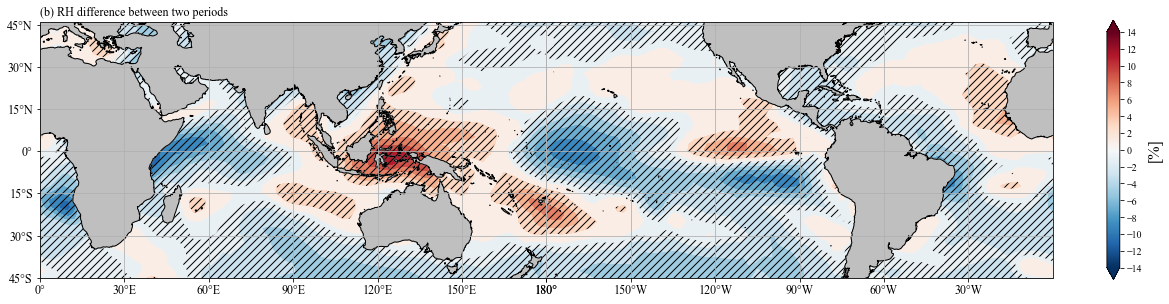

In [14]:
# 手调气象趋势
# 设置经纬度
# lon = longitude[:].data
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

plt.rc('font',family='Times New Roman') 
lon = np.append(longitude[:].data, [360.0])
lat = latitude[:].data

# print(len(lat))
# 调整经纬度 向东偏移180
# lon_pacific = lon[:] + 180
# a, b = np.hsplit(diff, [179])
# diff_pacific_contre = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据
diff_2d = diff[0]
new_diff=[]
for i in range(diff_2d.shape[0]):
    tmp = np.append(diff_2d[i], diff_2d[i][0])
    new_diff.append(tmp.tolist())
new_diff = np.array(new_diff)
print(new_diff.max(), new_diff.min())
def choose_95_percent(amax, amin):
    # 去掉中间 5%的部分
    middle = (np.abs(amax) + np.abs(amin)) * 0.5
    tmp = middle * 0.975
    bmax = amax - tmp
    bmin = amax - middle - bmax
    return round(bmax, 2), round(bmin,2)

point_max, point_min = choose_95_percent(new_diff.max(), new_diff.min())

fig = plt.figure(figsize=(15,5))

proj = ccrs.PlateCarree(central_longitude=180)
# proj = ccrs.PlateCarree()
leftlon, rightlon, lowerlat, upperlat = (-180, 180.1, -45, 46)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.contourf(lon, lat, new_diff,
                 # 显著性打点 p值为0.05
                [2, np.nanmax(new_diff)],
    #                  [0.01, 0.05, np.nanmax(p_value)],
                hatches=['///', None], colors="none",
                transform = ccrs.PlateCarree())  # 增加斜线

fig_ax1.contourf(lon, lat, new_diff,
                 # 显著性打点 p值为0.05
                [np.nanmin(new_diff), -1],
    #                  [0.01, 0.05, np.nanmax(p_value)],
                hatches=['///', None], colors="none",
                transform = ccrs.PlateCarree())  # 增加斜线

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,180.1,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
labels = fig_ax1.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]


fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(b) RH difference between two periods',loc='left',fontsize =12)

cont = fig_ax1.contourf(lon, lat, new_diff, 
                 levels=np.arange(-14,14.1,2), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)
# fig_ax1.contourf(lon, lat, diff,levels=[0,0.05,1], zorder=1, hatches=['....',None],colors="none", transform=ccrs.PlateCarree())

norm = colors.Normalize(vmin=-14, vmax=14)    #确定colormap的最大最小值

cmap=plt.cm.RdBu_r  #引用NCL的colormap

# newcolors=cmap(np.linspace(-14,15,9))#分片操作，生成0到1的12个数据间隔的数组   

# newcmap=ListedColormap(newcolors[::])  #重构为新的colormap


fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,
                                       cmap=plt.cm.RdBu_r
#                                        cmap = newcmap
                                      ),
#                  cax = fig.add_axes([0,0,0.05,0.9]),
                 orientation='vertical',
                 ticks=np.arange(-14,15,2).tolist(), # colorbar分片                                                 
                 extend='both',
                fraction=0.012) 
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16,
        }
fc1.set_label(label="[%]", fontdict=font) #设置colorbar的标签字体及其大小
# plt.colorbar(cont,fraction=0.012)

plt.savefig("diffCheck_rhum.png",dpi=300,bbox_inches='tight')
plt.show()